In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from configparser import ConfigParser
import itertools as itt
import pathlib as pl

import joblib as jl
import numpy as np
import xarray as xr
import pandas as pd

from webcolors import hex_to_rgb
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.optimize import minimize
from scipy.stats import sem

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from IPython.display import Image

from src.data.tensor_loaders import tensor_loaders
from src.dim_redux.PCA import unfold_for_PCA, refold_from_PCA
from src.metrics.simple_diff import ctx_effects_as_DF

from src.root_path import config_path, root_path
from src.utils.subsets import good_sites

from src.visualization.utils import squarefy, square_rows_cols
from src.visualization.interactive import plot_site_coverages, plot_raw_pair_array
from src.visualization.palette import Grey, TENCOLOR

# modules developed for this notebook
from src.models.decoder import get_svm_accuracy, decode_and_plot, unfold_rep_ctx_prb
from src.data.diagonalization import get_diagonalizations, plot_eg_diag, plot_ctx_clusters, diag_and_scale

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2023-03-08 113234.log


cannot connect to database, loading hardcoded sites
cannot connect to database, loading hardcoded cells. TODO!


In [3]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

# example from figure 1?
probe = 3
ctx_pair = [0,1]
cellid = 'ARM021b-36-8'

site = cellid.split('-')[0]

In [4]:
# fn = load_site_formated_raster
# loads caches rasters and PCA raster. Caches SHOULD exists, as these are used for the cluster mass analysis.

rasters, channels = dict(), dict()
for source in ['SC', 'PCA']:
    fn = tensor_loaders[source]
    if fn.check_call_in_cache(site, **raster_meta):
        rasters[source], channels[source] = fn(site, **raster_meta)
        print(f'####\n'
              f'{source} raster shape {rasters[source].shape}'
              f'\n{channels[source]}')
    else:
        print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")


####
SC raster shape (20, 33, 5, 4, 20)
['ARM021b-02-2', 'ARM021b-04-3', 'ARM021b-05-1', 'ARM021b-05-2', 'ARM021b-06-3', 'ARM021b-06-4', 'ARM021b-10-4', 'ARM021b-12-7', 'ARM021b-16-7', 'ARM021b-19-4', 'ARM021b-23-1', 'ARM021b-23-2', 'ARM021b-25-3', 'ARM021b-26-5', 'ARM021b-29-4', 'ARM021b-31-2', 'ARM021b-34-3', 'ARM021b-34-4', 'ARM021b-36-8', 'ARM021b-37-4', 'ARM021b-39-10', 'ARM021b-40-6', 'ARM021b-40-7', 'ARM021b-43-8', 'ARM021b-44-2', 'ARM021b-45-7', 'ARM021b-46-6', 'ARM021b-49-9', 'ARM021b-51-4', 'ARM021b-52-4', 'ARM021b-52-5', 'ARM021b-52-6', 'ARM021b-53-1']
####
PCA raster shape (20, 20, 5, 4, 20)
{'ARM021b-PC-1': 0.1259746190221689, 'ARM021b-PC-2': 0.10736787220331248, 'ARM021b-PC-3': 0.0856232326794926, 'ARM021b-PC-4': 0.07408560332407356, 'ARM021b-PC-5': 0.07249775864599521, 'ARM021b-PC-6': 0.061547002796786966, 'ARM021b-PC-7': 0.05670947779758218, 'ARM021b-PC-8': 0.04705047824582823, 'ARM021b-PC-9': 0.037880402295577605, 'ARM021b-PC-10': 0.03505485698189448, 'ARM021b-PC-11': 

# unfolds

our input is 5 dimensional arrays with shape Trial x Channel x Context x Probe x Time
for our decoding we want a 2d matrix with shape observation (trials) x features (channels)
and we will do the decoding independently at each time point.

Therefor we need to unfold it such that the end result is of shape Trials x Channel x Time
concatenating the dimension of context and probe into the Trials, while keeping a list of labels
specifying Context and Probe identities


In [5]:
raster = rasters['SC']
rep, chn, ctx, prb, tme = raster.shape
print(raster.shape)
unfolded, labels = unfold_rep_ctx_prb(raster)

print(unfolded.shape)
print(labels.shape)
print(labels)

(20, 33, 5, 4, 20)
(400, 33, 20)
(400, 3)
     trial  context  probe
0      0.0      0.0    0.0
1      0.0      0.0    1.0
2      0.0      0.0    2.0
3      0.0      0.0    3.0
4      0.0      1.0    0.0
..     ...      ...    ...
395   19.0      3.0    3.0
396   19.0      4.0    0.0
397   19.0      4.0    1.0
398   19.0      4.0    2.0
399   19.0      4.0    3.0

[400 rows x 3 columns]


# Predict
Using linear support vecotr machines, create a decoder that tries to infer the context or probe
identity based on the activity data. This is done indepenedently over time points.
To validate the quality of the decoder we calculate its prediction accuracy,
and to avoid overfitig we do this with cross validation.

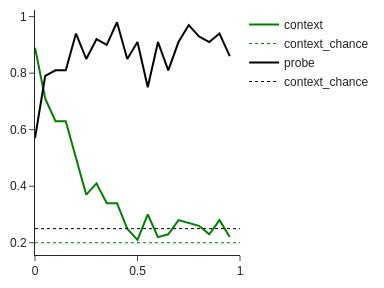

In [6]:
fig, _, _ = decode_and_plot(raster, 'plotly',showlegend=True)
fig.show(renderer="jpeg")

# Principal components
contain tangled information for both context and probe
As expected prediction accuracy increases with the number of components considered,
and it's higher for the Probe than the Context identity as expected,
furthermore, the starting accuracy is higher for probe than for context, which is expected.

In [7]:
PC_raster = rasters['PCA'] # slice PC1, keeping dimension

n_pcs = PC_raster.shape[1]
for ii in range(1,n_pcs, 5):
    # uses a slice of up to n components
    print(f'using {ii} PCs')
    fig, _, _ = decode_and_plot(PC_raster[:,np.arange(ii),...])
    # img_bytes = fig.to_image(format="png", scale=1)
    # Image(img_bytes)

using 1 PCs
using 6 PCs
using 11 PCs
using 16 PCs


# Average out ctx and probe

This commes as an alternative of shuffling for destroying context and/or probe information.
Furthermore, by averaging out some of the variance, we can then  perform PCA over rasters
containing only context information (marginal, similar to dPCA).

In [8]:
# destroy info by average, a dimension is lost, albeit kept as a singleton dim for broadcasting.
raster_prb = np.mean(raster, axis=2, keepdims=True) # average out context, contains only prb info
raster_ctx = np.mean(raster, axis=3, keepdims=True) # average out probe, contains only ctx info

# doese a substraction to broadcast the dimensions back to the right shape (after lossng a dim by average)
no_ctx_raster = raster - raster_ctx
no_prb_raster = raster - raster_prb
noise = raster - raster_ctx - raster_prb

fig, _, _ = decode_and_plot(raster)
fig, _, _ = decode_and_plot(no_ctx_raster)
fig, _, _ = decode_and_plot(no_prb_raster)
fig, _, _ = decode_and_plot(noise)

# Something looks fishy
hypothetically, adding together the different versions of the probe and context averaged (out) rasters, should yield
something similar to the original source raster, yet looking at the decoder performances and the total variances
this is not thew case.
This makes me think in non-orthogonality between context and probe dimensions...
shocking! (sarcasm, already observed/quantiffied with the old dPCA analysis)
this further proves the complexity of the context probe interaction and the can of worms I dont wanna open.

In [9]:
print('source raster variance: ', np.sum(np.var(raster, axis=(0,2,3,4))))
print('average ctx + prb variance: ', np.sum(np.var(raster_ctx+raster_prb, axis=(0,2,3,4))))
print('no_ctx + no_prb variance: ', np.sum(np.var(no_ctx_raster+no_prb_raster, axis=(0,2,3,4))))

_ = decode_and_plot(raster)
_ = decode_and_plot(raster_ctx+raster_prb)
_ = decode_and_plot(no_ctx_raster+no_prb_raster)

source raster variance:  43.02951784505011
average ctx + prb variance:  40.08028831340645
no_ctx + no_prb variance:  90.05792494855014


# Recover
now lets extract the best explaining context PCs, and sume them back to the no-context data
such that all neurons are holding the same amount of contexte information, i.e., a dense representation
1. remove probe information
2. run PCA on the raster containing context information only
3. project back n-PCs such that each PC is equally weighted across all the original neuron dimension

the tricky part lies in selecting the nature of the dense back projection.
Initially I weighted the PCs by their explained variance, i.e., artificially inflating the contribution of the most
relevant PCs, this sort of worked.
Later, by recomendation of SVD, I weighted the PCs equally, since they already contain different amounts
of variance, and capture all the variance we want to recover. This worked  much poorly.

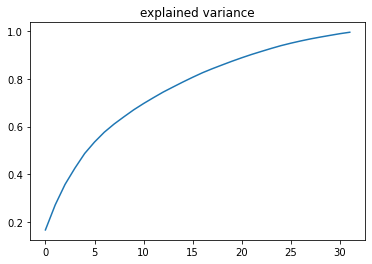

In [10]:
# fits data on trial averages, we don't want to fit noise.

# PCA of contextual effects alone
# Remove probe information array obtained by averaging out context info
no_prb_raster = raster - raster.mean(axis=2, keepdims=True)
assert len(no_prb_raster.shape) == 5
rep, neu, ctx, prb, tme = no_prb_raster.shape

reshaped = unfold_for_PCA(no_prb_raster.mean(axis=0, keepdims=True)) # train PCA over PSTH
# reshaped = unfold_for_PCA(no_prb_raster) # train PCA over single trials

pca = PCA(n_components=32) # change this to keep all components eventually
pca.fit(reshaped.T)

# using the PCs transforms all trials
# swap axes and collapse across all dimensions but neuron, does PCA, and reshapes back to normal.
transformed = pca.transform(unfold_for_PCA(no_prb_raster).T).T
nPCs = transformed.shape[0] # automatically detected to capture n_components of variance
shape = (rep, nPCs, ctx, prb, tme)
transformed = refold_from_PCA(transformed, shape)

_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))
_ = plt.title('explained variance')

_ = decode_and_plot(transformed)

#### how many principal components?
are requiered to recapitulate significant performance in the decoding accuracy??

/home/mateo/miniconda3/envs/context_probe_analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/home/mateo/miniconda3/envs/context_probe_analysis/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



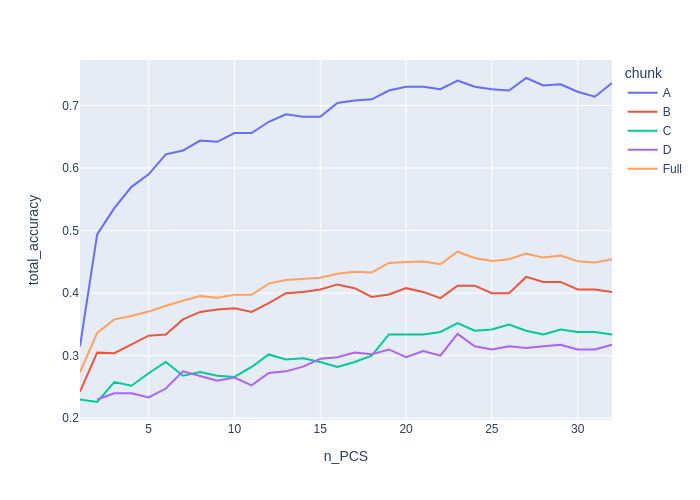

In [11]:
ufd, lbl = unfold_rep_ctx_prb(transformed)

agg_accuracy = list()
# calculate accuracy increase as a funcion of increasing number of principal components
for pp in range(ufd.shape[1]):
    acc, chz = get_svm_accuracy(ufd[:,np.arange(pp+1),:],
                                lbl['context'])
    d = dict()
    d['n_PCS'] = pp+1
    for cnk_nm, slcr in {"A":np.s_[:5], "B":np.s_[5:10], "C":np.s_[10:15], "D":np.s_[15:], "Full":np.s_[:],}.items():
        chunk = acc[slcr]
        # d[cnk_nm] = np.sum(chunk[chunk>chz])
        d[cnk_nm] = np.mean(chunk[chunk>chz])

    agg_accuracy.append(d)

agg_accuracy = pd.DataFrame(agg_accuracy)
agg_accuracy = pd.melt(agg_accuracy, id_vars=['n_PCS'], value_vars=['A','B','C','D','Full'],
                 var_name='chunk', value_name='total_accuracy')


# no plots the total accuracy (y) as a funciton of total PCs
fig = px.line(data_frame=agg_accuracy, x='n_PCS', y='total_accuracy', color='chunk')
img_bytes = fig.to_image(format="png",  scale=1)
Image(img_bytes)

#### piecemeal addition
of context info in a dense way. que question is how to weight the principal components, albeit for a given PC,
it will be equally weighted for all neurons

(32, 33)


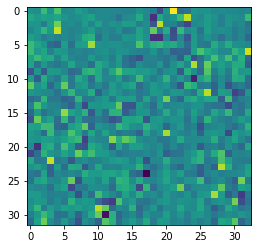

In [12]:
# the PCA components are showing us the weight of each componetn (y) used to recreate each neuron (x)
comps = pca.components_
print(comps.shape)
plt.imshow(comps)
# idealy we want each component to be equally weighted across all neurons (horizontal lines).
# however different components should have overall different weights to preserve variance

original summed var across neurons 4.878957093475751
summed var across principal components 4.868332529501108
dense_weigths shape (32, 33)
dense_weights var explained 1.0


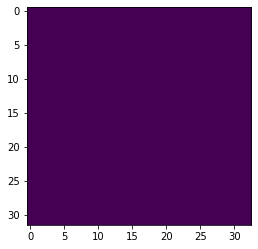

In [13]:
target_var = np.sum(np.var(reshaped, axis=1))
print('original summed var across neurons', target_var)
print('summed var across principal components', np.sum(pca.explained_variance_))

n_cells = no_ctx_raster.shape[1]

# dense_weights = np.tile(pca.explained_variance_[:,np.newaxis], [1,n_cells]) # MLE: PCs weighted by eigenvalue
dense_weights = np.ones(comps.shape)/np.sqrt(comps.shape[1]) # SVD: all PCS equally weighted

print('dense_weigths shape', dense_weights.shape)
print('dense_weights var explained', np.sqrt(np.sum((dense_weights[0,:])**2)))# root mean sum should be == 1
plt.imshow(dense_weights)

dense variance 4.856161698177356
dense variance corrected 4.878957093475748


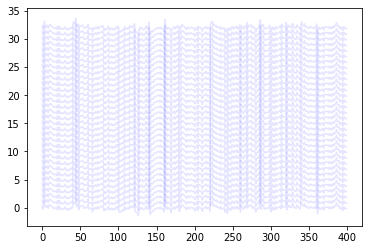

In [14]:
# now lets transform the principal components back into dense cells
trans = pca.transform(reshaped.T)
dense = (trans @ dense_weights).T

print('dense variance',np.sum(np.var(dense, axis=1)))

# all output cells are equal and have equal variance, To adjust it we jut need to find
# a scalar to equally scale all output vectors

v_var = np.var(dense, axis=1)[0] # variance per component
scaler = np.sqrt(target_var / dense.shape[0]) / np.sqrt(v_var)

print('dense variance corrected',np.sum(np.var(dense*scaler, axis=1)))
# _ = plt.plot(dense.T, color='gray', alpha=0.1)
_ = plt.plot(dense.T*scaler + np.arange(33)[None,:], color='blue', alpha=0.1)

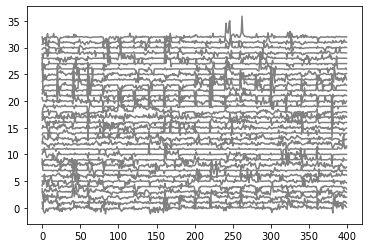

In [15]:
_ = plt.plot(reshaped.T + np.arange(33)[None,:], color='gray', alpha=1)

In [16]:
# now lets transform the principal components back into dense cells\
resh = unfold_for_PCA(no_prb_raster) # 5d -> 2d
trans = pca.transform(resh.T)
dense = (trans @ dense_weights).T
print('dense variance',np.sum(np.var(dense, axis=1)))

# all output cells are equal and have equal variance, To adjust it we jut need to find
# a scalar to equally scale all output vectors
target_var = np.sum(np.var(resh, axis=1))
print("target variance ", target_var)
v_var = np.var(dense, axis=1)[0] # variance per component
scaler = np.sqrt(target_var / dense.shape[0]) / np.sqrt(v_var)

print('dense variance corrected',np.sum(np.var(dense*scaler, axis=1)))
# _ = plt.plot(dense.T, color='gray', alpha=0.1)
# _ = plt.plot(dense.T*scaler, color='blue', alpha=0.1)

dense variance 24.45892050242785
target variance  24.346811929542977
dense variance corrected 24.34681192954293


In [17]:
# refold the dense transofmration
dense_folded = refold_from_PCA(dense, no_prb_raster.shape)

print(np.sum(np.var(no_prb_raster, axis=(0,2,3,4))))
print(np.sum(np.var(dense_folded, axis=(0,2,3,4))))

_ = decode_and_plot(no_prb_raster)
_ = decode_and_plot(dense_folded)

24.34681192954298
24.45892050242785


In [18]:
reconstituted = no_prb_raster + no_ctx_raster
dense_raster = no_ctx_raster + dense_folded # dense context


print(np.sum(np.var(raster, axis=(0,2,3,4))))
print(np.sum(np.var(reconstituted, axis=(0,2,3,4))))
print(np.sum(np.var(dense_raster, axis=(0,2,3,4))))

_ = decode_and_plot(raster)
_ = decode_and_plot(reconstituted)
_ = decode_and_plot(dense_raster)

43.02951784505011
90.05792494855014
59.02358264196709


#### something is off
I must have missed something, and variances are not consistent. albeit the densification of the context seems
to be hindering decoding, as expected!!
Having consisten variances will be needed to give more strength to this densification procedure.-

# context effect quantification

now lets to a really simple quantification of the context pairwise differences, akin to the context mass
analysis, but simpliffied and deterministic i.e. more similar to the approach used with the deterministic
model predictions.

lots of this code is inspired and/or copied over from the model analysis pipeline:
src/models/param_tools.py get_pre_err
220412_resp_vs_pred_metrics.py

In [19]:
cellids = channels['SC']
sparse_DF = ctx_effects_as_DF(raster, cellids, raster_meta['raster_fs'])
dense_DF = ctx_effects_as_DF(dense_raster, cellids, raster_meta['raster_fs'])

# Raw visualization

show fingerprints of context modulation space for multiple neurons in a site

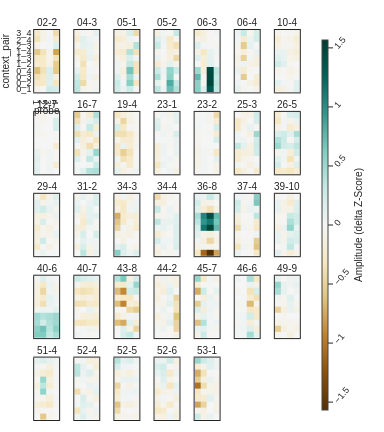

In [20]:
fig = plot_site_coverages(sparse_DF.query("chunk == 'Full' "), cellids[:])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

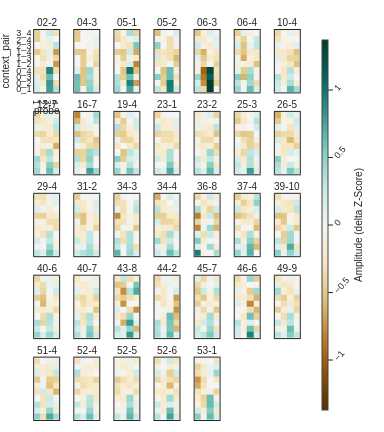

In [21]:
fig = plot_site_coverages(dense_DF.query("chunk == 'Full' "), cellids[:])
img_bytes = fig.to_image(format="png")
Image(img_bytes)

-16.541062222380198 -71.16192383451298


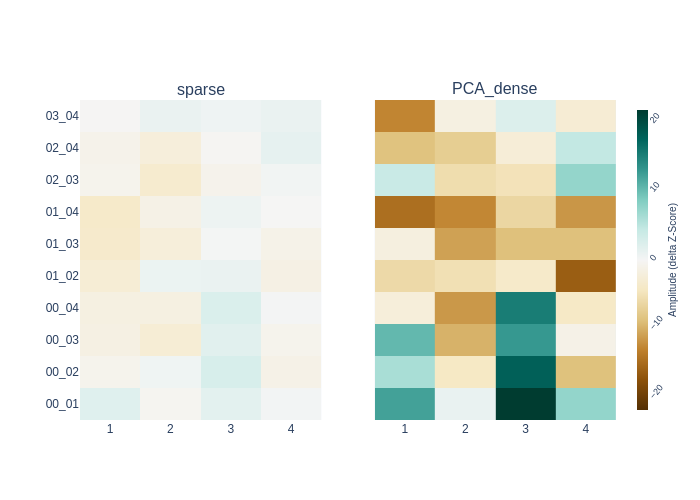

In [22]:
print(sparse_DF.query("chunk == 'Full'").value.sum(),
      dense_DF.query("chunk == 'Full'").value.sum())

fig = make_subplots(1, 2, subplot_titles=['sparse', 'PCA_dense'])
_ = fig.add_trace(
    px.density_heatmap(sparse_DF.query("chunk == 'Full'"),
                       x='probe', y='context_pair', z='value',
                       histfunc='sum')['data'][0],
    row=1, col=1
)

_ = fig.add_trace(
    px.density_heatmap(dense_DF.query("chunk == 'Full'"),
                       x='probe', y='context_pair', z='value',
                       histfunc='sum')['data'][0],
    row=1, col=2
)

_ = fig.update_layout(coloraxis=dict(showscale=True,
                                     colorscale='BrBg',
                                     cmid=0,
                                     colorbar=dict(
                                         orientation='v',
                                         thicknessmode='fraction',
                                         thickness=0.02,
                                         lenmode='fraction',
                                         len=1,
                                         title=dict(text='Amplitude (delta Z-Score)',
                                                    side='right',
                                                    font_size=10),
                                         tickangle=-50,
                                         tickfont_size=9,
                                     )))

img_bytes = fig.to_image(format="png")
Image(img_bytes)


# Geometrical interpretation

In light of the previous failure with PC projections, I atempted to go back into a more "manual" densification
process.

Thinking about it, dense means that all neurons are contributing equally to the pairwise differences
seen between instances.

From a geometric perspective this means that the dx == dy for a system of 2 neuron x and y, where d is the
delta between contexts. This forms an isosceles triangle where the cathetus are defined by the Manhattan distance,
and the hypotenuse is defined by the euclidean distance.

In summary, a "densification" process is characterized by an isocelization, where the L1 (manhattan) is mantained
and the L2 (euclidean) is minimized.

In [23]:
def plot_distances(V1, V2):
    x1 = V1[0]
    y1 = V1[1]
    x2 = V2[0]
    y2 = v2[1]

    L1 = np.linalg.norm(V1-V2, ord=1)
    L2 = np.linalg.norm(V1-V2, ord=2)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[x1,x2], y=[y1,y2], mode='markers', marker_color='black', name='instances'))
    fig.add_trace(go.Scatter(x=[x1,x1,x2], y=[y1,y2,y2], mode='lines', line_color='gray', line_dash='dot',
                             name='Manhattan distance'))
    fig.add_trace(go.Scatter(x=[x1,x2], y=[y1,y2], mode='lines', line_color='pink', line_dash='dot',
                             name='Euclidean distance'))

    # distances, L1 and L2
    fig.add_trace(go.Scatter(x=[x1-L1,x1, x1+L1, x1, x1-L1],
                             y=[y1, y1+L1, y1, y1-L1, y1],
                             mode='lines', line_color='black', line_dash='dot',
                             showlegend=False))

    fig.add_shape(type="circle", xref="x", yref="y",
                  x0=x1-L2, y0=y1-L2, x1=x1+L2, y1=y1+L2,
                  line_color="red", line_dash='dot')

    fig.update_xaxes(constrain='domain', range=[0,5], title_text='neuron 2 activity (AU)')
    fig.update_yaxes(scaleanchor='x', scaleratio=1, constrain='domain', range=[0,5],
                     title_text='neuron 1 activity (AU)')
    fig.add_vline(0)
    fig.add_hline(0)

    return fig

sparse L1:  2.23606797749979
sparse L2:  3.0


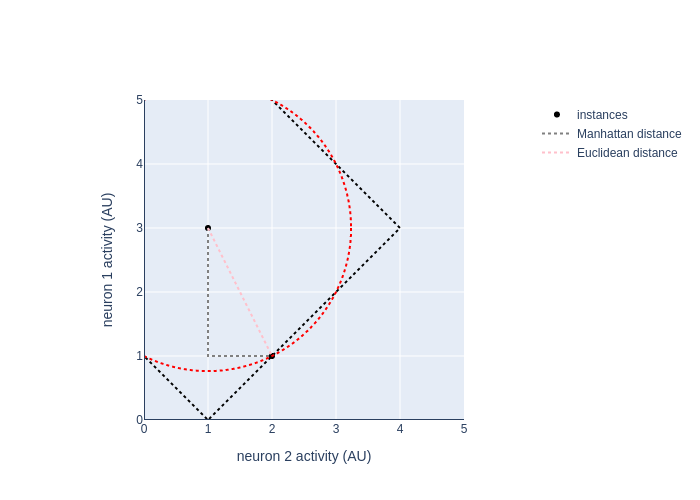

In [24]:
# eg original vectors
v1 = np.asarray([1,3])
v2 = np.asarray([2,1])

print('sparse L1: ', np.linalg.norm(v1-v2, ord=2))
print('sparse L2: ', np.linalg.norm(v1-v2, ord=1))

fig = plot_distances(v1, v2)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

dense L1:  2.1213203435596424
dense L2:  3.0


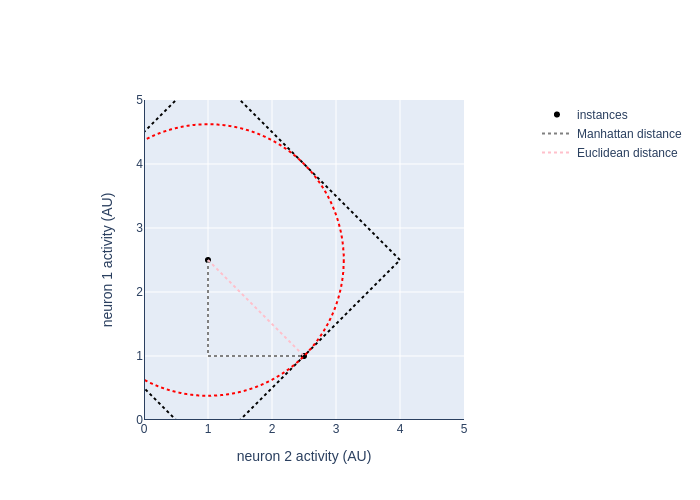

In [25]:
# densiffiend vectors
d1 = np.asarray([1,2.5,0])
d2 = np.asarray([2.5,1,0])
print('dense L1: ', np.linalg.norm(d1-d2, ord=2))
print('dense L2: ', np.linalg.norm(d1-d2, ord=1))

fig = plot_distances(d1, d2)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## Keep L1, minimize L2

its is clear that the way of reaching an isosceles triangle is to mantain the L1 distance (total neuronal activity),
while minimizing the L2 distance. This has strong implications!, as the L2 is reduces, so is the discriminability of
clounds of points around a centroid, in other words, the densification of neuronal responses leads to a less clear and
different representation of contexts.

Lets automitize this by defining a transformation of our points in state space and a loss function
such that we can tweak the transformation while minimizing loss.

the transformation is simply the motion of point in 2d coordinates ie. addign different xy offsets to every point

the loss function is a little bit more involved: keeping all the pairwise L1 norms, while minimizing all L2 norms.
this effectively forces points to form isoceles triangles between points


In [26]:
def densify(offsets, vctrs):
    """stacked list of 2(n) dimensional vectors"""
    assert offsets.size == vctrs.size

    # calculate pairwise L1 from original values that we must preserve
    L1o = pdist(vctrs, metric='cityblock') / vctrs.shape[1]

    moved = np.reshape(vctrs.flatten() + offsets.flatten(), vctrs.shape)

    # loss is a combination of preserving L1 and reducing L2 and remaining close to the original position
    L1 = pdist(moved, metric='cityblock') / vctrs.shape[1]
    L2 = pdist(moved, metric='euclidean')
    shift = np.linalg.norm(offsets.reshape(vctrs.shape), ord=2, axis=1)

    loss = np.sum(L2) + np.sum((L1-L1o)**2) + np.sum(shift) * 0.01
    return  loss

# test
vctrs = np.asarray([[1,3],
                    [2,1]])
print(pdist(vctrs))
print(densify(np.zeros_like(vctrs), vctrs))

[2.23606798]
2.23606797749979


In [27]:
vctrs = np.asarray([[1,3],
                    [2,1],
                    [4,2],
                    [5,7],
                    [7,5]
                    ])

progress = list()
progress_val = list()
def cb(x):
    transformed = vctrs + x.reshape(vctrs.shape)
    progress.append(transformed)
    progress_val.append(densify(x, vctrs))

res = minimize(densify, np.zeros_like(vctrs), method='nelder-mead',
               args=vctrs, options={'xatol': 1e-8, 'disp': False}, callback=cb)

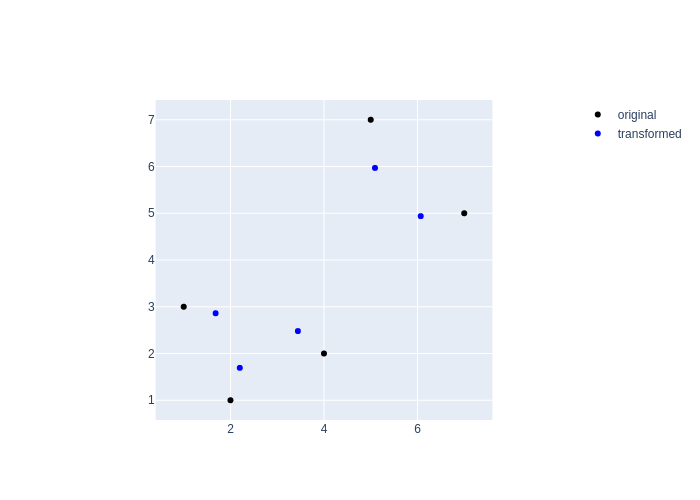

In [28]:
transformed = vctrs + res.x.reshape(vctrs.shape)

np.diff(transformed, axis=0)
fig = go.Figure()
_ = fig.add_trace(go.Scatter(x=vctrs[:,0], y=vctrs[:,1],
                             mode='markers', marker_color='black', name='original'))
_ = fig.add_trace(go.Scatter(x=transformed[:,0], y=transformed[:,1],
                             mode='markers', marker_color='blue', name='transformed'))
fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor='x', scaleratio=1, constrain='domain')
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [29]:
# this is a short animation showing the evolution of the points as the transformation is optimizede.
# for some reasone plotly is failing to display things
plot_progress = False

if plot_progress:
    # transforms the list of positions into a x,y wide, time-long dataframe for plotly animation
    timeDF = list()
    # just save 5 second video at fps
    dur = 5
    fps = 30
    for ii in range(0, len(progress), int(len(progress)/(dur*fps))):
        poss = progress[ii]
        data = np.concatenate([poss, np.arange(poss.shape[0])[:,None]], axis=1)
        df = pd.DataFrame(data=data, columns=['x', 'y', 'vctr'])
        df['iter'] = ii
        timeDF.append(df)

    timeDF = pd.concat(timeDF)

    fig = px.scatter(timeDF, x="x", y="y", animation_frame="iter", animation_group='vctr')

    # constrain the whole animation to 5 seconds
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = (1/fps)*1000*0.7
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = (1/fps)*1000*0.3
    fig.update_xaxes(constrain='domain')
    fig.update_yaxes(scaleanchor='x', scaleratio=1, constrain='domain')
    fig.show()

# context effect diagonalization
1. remove trial average probe effects, this should center the contexts around the mean
2. measure the trial average context effects Manhattan distance from the origin
3. move the context effects towards the equality diagonal i.e. all neurons are equally active, ensuring Manhattan distance is retained
4. add back in the probe effects
5. keep track of the transformations of the original data and apply to single trial matrices
5. measure the pairwise contextual effects

the rational here is that by diagonalizing the context effects, we aredensifying them, i.e.
all neuron are contributing the same firing rate. furthermore, if we consider pairwise comparisons between contexts
since they are on the same diagonal, their euclidena distance and their manhattan distances are forming an isoceles
triangle, which is asociated with dense representations.

In [30]:
folder = root_path / 'reports' / 'figures' / 'decoder'
folder.mkdir(parents=True, exist_ok=True)

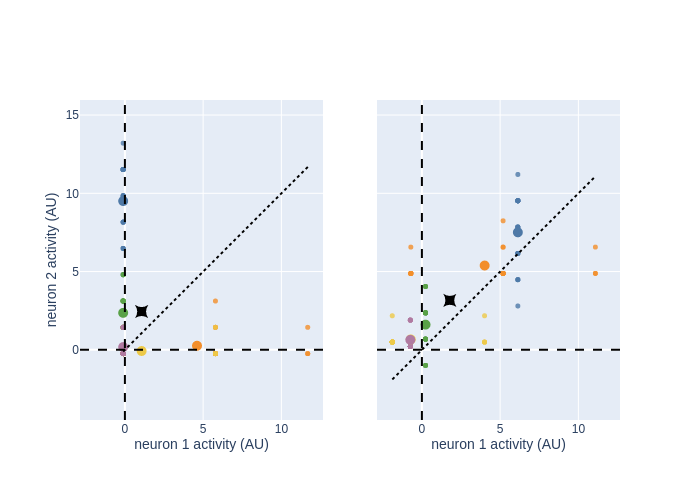

In [31]:
cellidx = [cellids.index("ARM021b-"+ci) for ci in ['06-3', '36-8']]
cellidx = [19,21]
# diagonalization of data with no probe info
test_raster = raster[:,np.asarray(cellidx),...][...,0,0][:,:,:,None,None] # 2 neurons, 1 probe, 1 time point
test_diagonalizer = get_diagonalizations(test_raster)

prb_psth = test_raster.mean(axis=(0,2), keepdims=True) # average out contexts -> probe centroids

fig = plot_eg_diag([test_raster, test_raster+test_diagonalizer])

filename = folder / 'diagonalization_trials'
fig.write_image(filename.with_suffix('.png'), scale=1)

img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [32]:
# we spect total variance across all neurons to be the same for the original data
# and the diagonalized data, this is not the case
# calculate the variance across all neurons in both cases
test_var = test_raster.var(axis=(0,2,3,4)).squeeze()
print(f"e.g. neurons var = {test_var},  total var {test_var.sum()}")
diag_var = (test_raster+test_diagonalizer).var(axis=(0,2,3,4)).squeeze()
print(f"e.g. diag-neurons var = {diag_var},  total var {diag_var.sum()}")

e.g. neurons var = [ 7.64986097 15.03671463],  total var 22.686575603166595
e.g. diag-neurons var = [12.084915   9.5792768],  total var 21.66419180396192


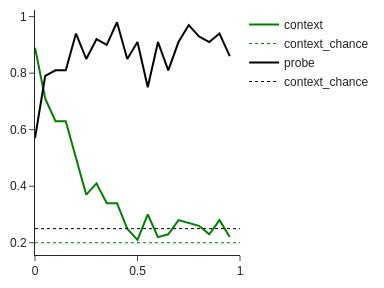

In [33]:
fig, _, _ = decode_and_plot(raster)
fig.show(renderer='jpeg')

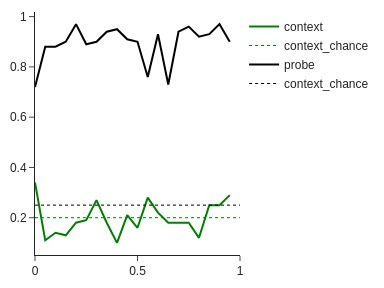

In [34]:
diagonalizer = get_diagonalizations(raster)
fig, _, _ = decode_and_plot(raster + diagonalizer)
fig.show(renderer='jpeg')

# Control for variance

After a talk with SVD, we figured that the right value to preserve during diagonalization is the variance
sumemd across all neurons. There is two parts to this:
1. Simply diagonalizing the value alters this total variance
2. if we need to scale the responses to match the variance
3. we should ensure preserving fano factors
with this two contstrains in mind, the following optimization is performed

the key identity here is how the variance changes with multiplication
*var(CX) = C<sup>2</sup> var(X)*


furtehremore, the variance can be decomposed in wat comes from within contexts clusters
and what comes from between the means of these clusters

$$Var(X) =  Var_{c}(X) + Var_{m}(X)$$

where the variance parts are defined as

$$Var_{c}(X_{i,j}) = \frac{1}{c} \sum \limits _{i=1} ^{c} Var(X_{i,:})$$


$$Var_{m}(X_{i,j}) = \frac{1}{c} \sum \limits _{i=1} ^{c} \bigg(\frac{1}{t} \sum \limits _{j=1}^{t} X_{i,:} \bigg) ^{2} - \bar{X}$$

and concerning fano factors, even simpler
*fano(CX) = C fano(X)*

which is inconvenient, since it implies that any scaling of the data to acchieve certain variance,
will necesarilly alter the fano factor.

We have therefore two conditions


$$Fano(X') = \frac{S_{c}^{2} Var_{c}(X) + S_{m}^{2} Var_{m}(X)}
                       {S_{m}{X}}$$

$$Var(X') = S_{c}^{2} Var_{c}(X) + S_{m}^{2} Var_{m}(X)$$



In [35]:
# function that relates the var and means of rows or columns to the total var
def var_from_marginal(row_or_col_means: np.ndarray,
         row_or_col_vars: np.ndarray
         ) -> float:
    total_mean = (row_or_col_means).mean()
    result = (row_or_col_vars + row_or_col_means**2).mean() - total_mean**2
    return result

def centroid_var(fnArr):
    return (fnArr.mean(axis=0, keepdims=True)**2).mean(axis=2, keepdims=True) - \
               fnArr.mean(axis=(0,2), keepdims=True)**2

def cluster_var(fnArr):
    return fnArr.var(axis=0, keepdims=True).mean(axis=2, keepdims=True)

def fano(fnArr, axis=None, keepdims=False):
    return np.var(fnArr, axis=axis, keepdims=keepdims) / np.mean(fnArr, axis=axis, keepdims=keepdims)



target var=[ 7.64986097 15.03671463], sum=22.686575603166595, fano=[7.15353322 6.15230774]

scaled var=[11.3432878 11.3432878], sum=22.686575603166595, fano=[7.15353322 6.15230774]


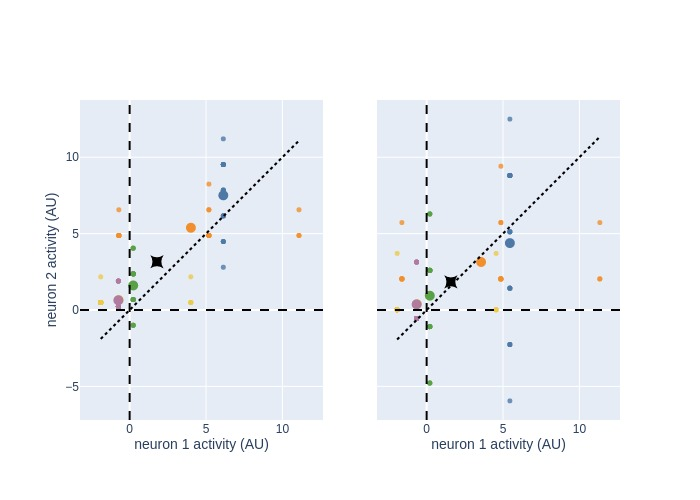

In [36]:
# after some long algebra ordeals, I think i figured out two scalers, for individual clusters and for the clusters means
# such that the resulting scaled diagonalization, matches both the desired variance and  fano factors of the original
# data, lets see if it works
test_diag = test_raster + get_diagonalizations(test_raster)

TarVar = np.tile(test_raster.var(axis=(0,2), keepdims=True      # trials and contexts are the sources of var
                             ).sum(axis=(1), keepdims=True)/test_raster.shape[1],
                     (1,test_raster.shape[1],1,1,1))# Sum across neurons
TarFano = fano(test_raster, axis=(0,2,3,4), keepdims=True)

ClustVar = cluster_var(test_diag)
MeanVar = centroid_var(test_diag)
Mean = np.mean(test_diag, axis=(0,2,3,4), keepdims=True)


# Scaler for the (cluster) means
Sm = TarVar / (TarFano * Mean)

# Scaler for the clusters, alas is one for all
Sc = np.sqrt((TarVar - Sm**2 * MeanVar) / ClustVar)

ctx_psth =  test_diag.mean(axis=(0,3), keepdims=True) # averages out probe and trials -> context psth
no_ctx = test_diag - ctx_psth

test_scaled = no_ctx * Sc + ctx_psth * Sm

scaled_fano = fano(test_scaled, axis=(0,2,3,4), keepdims=True)
scaled_var = test_scaled.var(axis=(0,2), keepdims=True)

print(f'\ntarget var={test_raster.var(axis=(0,2)).squeeze()}, sum={test_raster.var(axis=(0,2)).sum()}, fano={TarFano.squeeze()}')
print(f'\nscaled var={scaled_var.squeeze()}, sum={scaled_var.sum()}, fano={scaled_fano.squeeze()}')

fig = plot_eg_diag([test_diag, test_scaled])
fig.show(renderer='jpeg')

#### scaling functionalized
same procedure as last panel, but performed by a nice function elsewhere

target var=[ 7.64986097 15.03671463], sum=22.686575603166595, fano=[7.15353322 6.15230774]
scaled var=[11.3432878 11.3432878], sum=22.686575603166595, fano=[7.15353322 6.15230774]


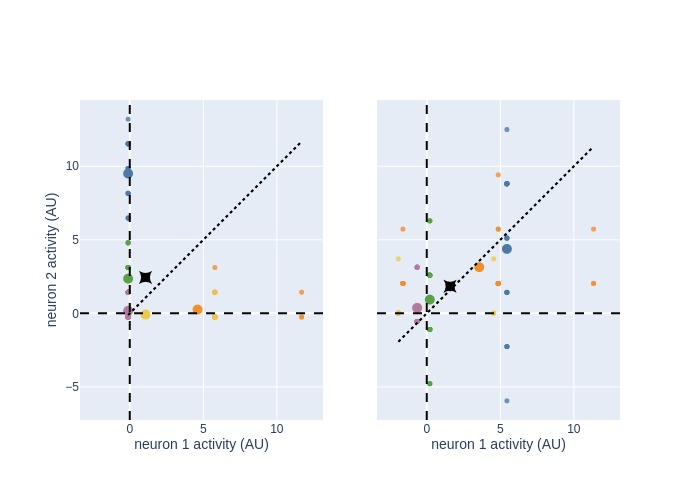

In [37]:
test_scaled2 = diag_and_scale(test_raster, verbose=True)
scaled_var2 = test_scaled2.var(axis=(0,2,3,4))
scaled_fano2 = fano(test_scaled2, axis=(0,2,3,4))

fig = plot_eg_diag([test_raster, test_scaled2])
fig.show(renderer='jpeg')

#### a much simpler approach
simply ignore the fano factor requirement and instead keep cluster variance fixed
the only source of variance is the cluster centroids, where we will scale independently
of the cluster trials themselves

target var=[ 7.64986097 15.03671463], sum=22.686575603166595, fano=[7.15353322 6.15230774]
scaled var=[12.5961069 10.0904687], sum=22.686575603166606, fano=[6.83791431 3.09402525]


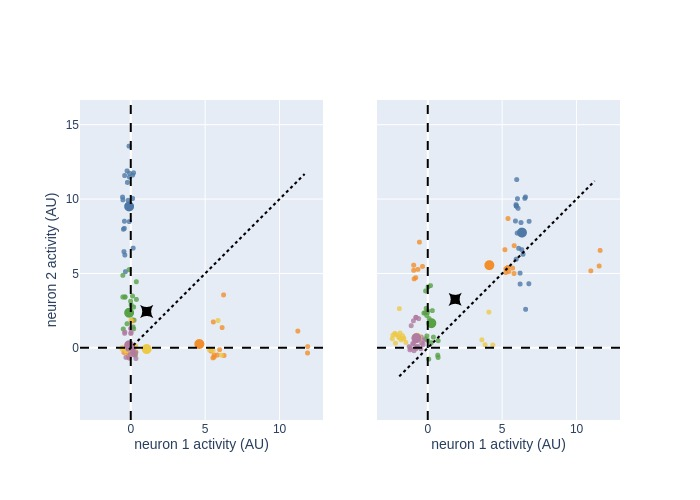

In [117]:
test_scaled2 = diag_and_scale(test_raster, mode='mean_var', verbose=True)
scaled_var2 = test_scaled2.var(axis=(0,2,3,4))
scaled_fano2 = fano(test_scaled2, axis=(0,2,3,4))

fig = plot_eg_diag([test_raster, test_scaled2], jitter=0.5)
fig.show(renderer='jpeg')

#### full site
and decoder, this showed a lot of issues with the complex fano-variance scaler, namely a lot of numerical instability:
div0, sqrt(-) and inf. I had to hack it and force a lot of nan and infs to 1 (no scaling).
This might do some odd transformations, which in turn might increase the discriminability over what is observed with
simpler scalings

square of negative 53
div by 0 in ClustVar 606


/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

invalid value encountered in sqrt



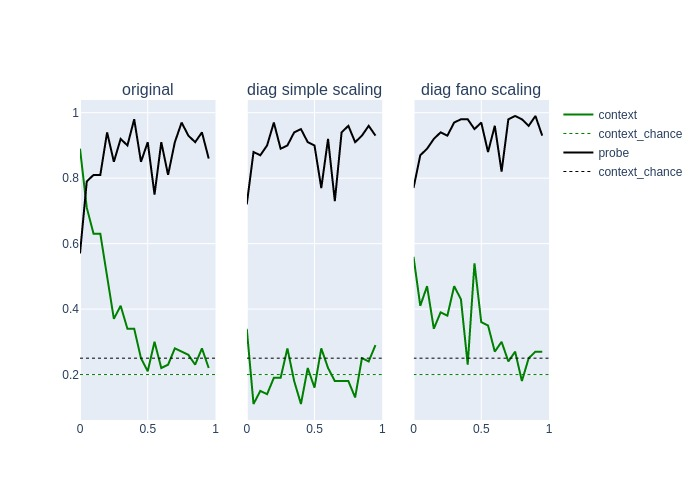

In [39]:
mean_var_diag = diag_and_scale(raster, mode='mean_var')
fano_var_diag = diag_and_scale(raster, mode='fano_var')

fig = make_subplots(rows=1, cols=3, shared_yaxes='all', shared_xaxes='all',
                    subplot_titles=['original', 'diag simple scaling', 'diag fano scaling'])

for cc, arr in enumerate([raster, mean_var_diag, fano_var_diag]):
    showlegend = True if cc == 0 else False
    f, _, _ = decode_and_plot(arr,showlegend=showlegend)
    f = f['data']
    fig.add_traces(f, rows=[1]*len(f), cols=[cc+1]*len(f))

fig.show(renderer='jpeg')

This unexpected increase in the decoder performace has to be investigated. It might be an outright deal-breaker for the
more complicated scaling. at least we can preserve variance with the more straightforward centroid scaling.

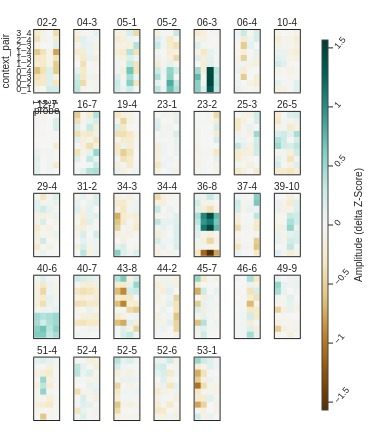

In [106]:
fig = plot_site_coverages(sparse_DF.query("chunk == 'Full' "), cellids[:])

# filename = folder / 'sparse_summed_coverage'
# fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')

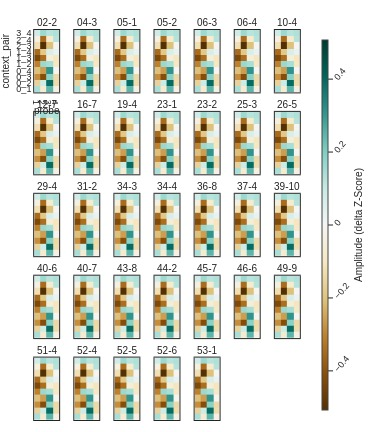

In [107]:
diag_DF = ctx_effects_as_DF(mean_var_diag, cellids, raster_meta['raster_fs'])
fig = plot_site_coverages(diag_DF.query("chunk == 'Full' "), cellids[:])

# filename = folder / 'dense_summed_coverage'
# fig.write_image(filename.with_suffix('.png'), scale=1)
fig.show(renderer='jpeg')

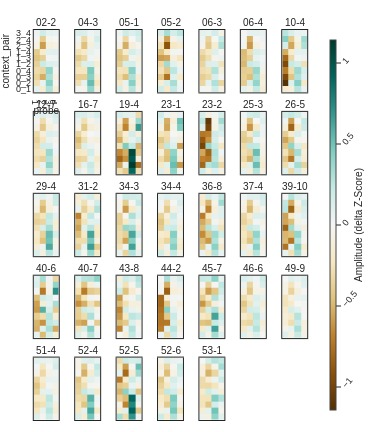

In [108]:
fano_DF = ctx_effects_as_DF(fano_var_diag, cellids, raster_meta['raster_fs'])
fig = plot_site_coverages(fano_DF.query("chunk == 'Full' "), cellids[:])

# filename = folder / 'dense_summed_coverage'
# fig.write_image(filename.with_suffix('.png'), scale=1)
fig.show(renderer='jpeg')

-16.541062222380198 -83.31232767437388 -88.38207807105843


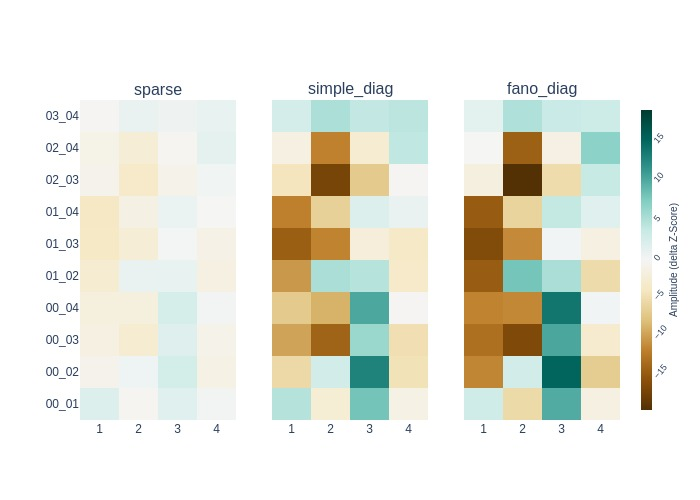

In [113]:
print(sparse_DF.query("chunk == 'Full'").value.sum(),
      diag_DF.query("chunk == 'Full'").value.sum(),
      fano_DF.query("chunk == 'Full'").value.sum(),
      )
all_dfs = {
    'sparse': sparse_DF,
    'simple_diag': diag_DF,
    'fano_diag': fano_DF,
}



fig = make_subplots(1, len(all_dfs), subplot_titles=list(all_dfs.keys()))

for cc, df in enumerate(all_dfs.values()):
    _ = fig.add_trace(
        px.density_heatmap(df.query("chunk == 'Full'"),
                           x='probe', y='context_pair', z='value',
                           histfunc='sum')['data'][0],
        row=1, col=cc+1
    )

_ = fig.update_layout(coloraxis=dict(showscale=True,
                                     colorscale='BrBg',
                                     cmid=0,
                                     colorbar=dict(
                                         orientation='v',
                                         thicknessmode='fraction',
                                         thickness=0.02,
                                         lenmode='fraction',
                                         len=1,
                                         title=dict(text='Amplitude (delta Z-Score)',
                                                    side='right',
                                                    font_size=10),
                                         tickangle=-50,
                                         tickfont_size=9,
                                     )))

# filename = folder / 'OG_and_diag_site_coverages'
# fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')

#### dig into the problem
the example used to develop the fano var scaling seems to be too well behaved, and the approach breaks for
other instances

In [86]:
simple_diag= diag_and_scale(raster, mode='mean_var', return_problem=False)
fano_diag, (Sm, Sc) = diag_and_scale(raster, mode='fano_var', return_problem=True)

print(Sm.shape)
print(f"problems in mean scaler:{np.any(~np.isfinite(Sm))}")
print(f"problems in cluster scaler:{np.any(~np.isfinite(Sc))}")
pwhere = np.argwhere(~np.isfinite(Sc))
print(f"{len(pwhere)} problematic instancese, {len(pwhere)/Sc.size* 100} of all")
pd.DataFrame(data=pwhere[:,[1,3,4]], columns=['cellidx', 'probe', 'time'])

square of negative 53
div by 0 in ClustVar 606
(1, 33, 1, 4, 20)
problems in mean scaler:False
problems in cluster scaler:True
655 problematic instancese, 24.810606060606062 of all


/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:94: RuntimeWarning:

invalid value encountered in sqrt



,cellidx,probe,time
0,0,3,0
1,1,2,6
2,1,3,0
3,2,3,0
4,3,0,0
...,...,...,...
650,32,2,13
651,32,3,0
652,32,3,7
653,32,3,8


uncorrected problematic Sc cell1:nan,cell2:nan
matching Sm cell1:2.1405167741111413,cell2:2.1817180551679245


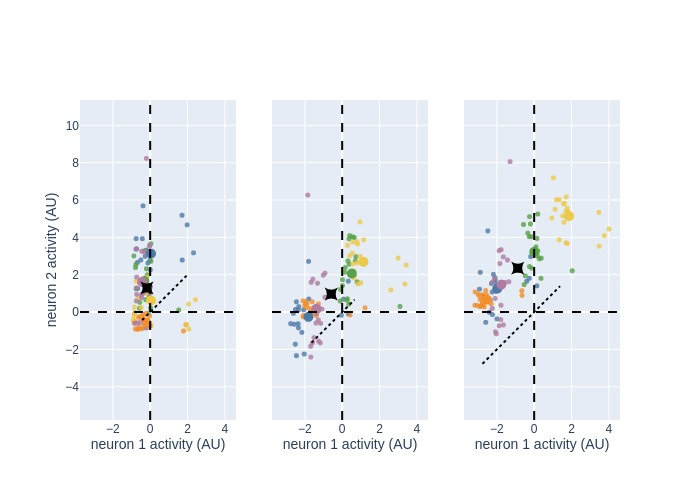

In [115]:
badcells, badprobe, badtime = [1,2], 3, 0
# badcells, badprobe, badtime = [0,1], 2, 6
print(f"uncorrected problematic Sc cell1:{Sc[0,badcells[0],0,badprobe,badtime]},"
      f"cell2:{Sc[0,badcells[1],0,badprobe,badtime]}")
print(f"matching Sm cell1:{Sm[0,badcells[0],0,badprobe,badtime]},"
      f"cell2:{Sm[0,badcells[1],0,badprobe,badtime]}")


# select a problematic subset: 2 neurons, 1 probe, 1 time point
bad_raster = raster[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]
simp_diag = simple_diag[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]
bad_diag = fano_diag[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]


fig = plot_eg_diag([
    bad_raster,
    # bad_raster.mean(axis=0, keepdims=True),
    simp_diag,
    # simp_diag.mean(axis=0, keepdims=True),
    bad_diag,
    # bad_diag.mean(axis=0, keepdims=True)
], jitter=0.5)

fig.show(renderer='jpeg')
# fig = plot_eg_diag([bad_raster, bad_diag])
# fig.show(renderer='jpeg')

# other neurons
clearly the mean probe effect is there, and the context effects have been greatlyu diminished.
will the same be true for other neurons in this site??

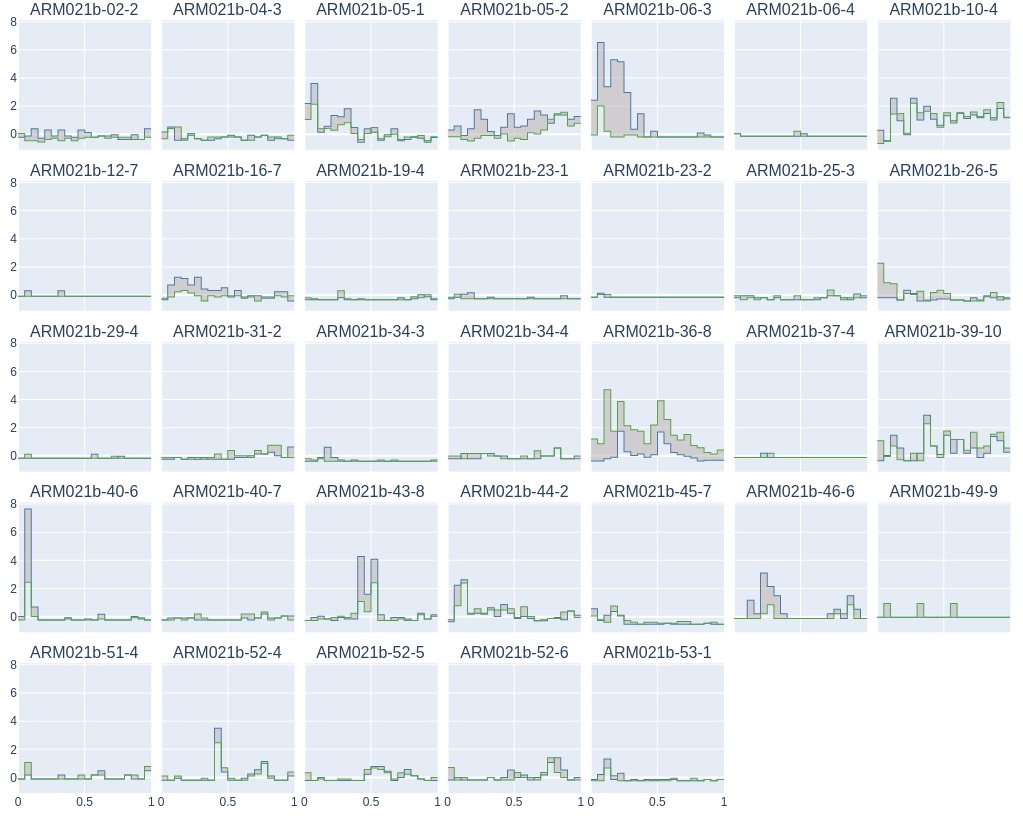

In [52]:
rows, cols = square_rows_cols(len(cellids))
fig = make_subplots(rows, cols, shared_xaxes='all', shared_yaxes='all', subplot_titles=cellids,
                    horizontal_spacing=0.01, vertical_spacing=0.04)

for ii, (rr, cc) in enumerate(itt.product(range(rows), range(cols))):
    if ii == len(cellids): break
    traces = plot_raw_pair_array(raster, cellids, cellids[ii], ctx_pair, probe, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend)['data']
    fig.add_traces(traces, rows=[rr+1]*len(traces), cols=[cc+1]*len(traces))

fig.update_traces(line=dict(width=1))
fig.update_layout(width=104*25/2.54, height=104*20/2.54,
                  margin=dict(l=10, r=10, t=20, b=10),
                  showlegend=False)

filename = folder / 'OG_site_eg_psths'
fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')

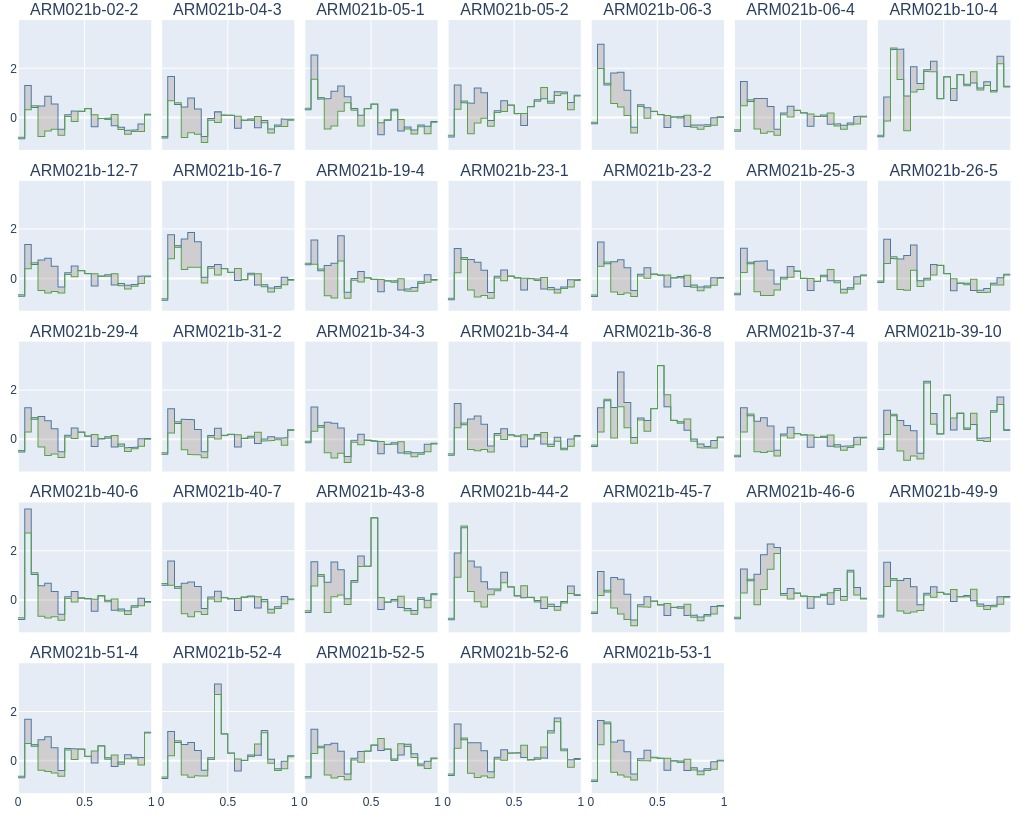

In [112]:
rows, cols = square_rows_cols(len(cellids))
fig = make_subplots(rows, cols, shared_xaxes='all', shared_yaxes='all', subplot_titles=cellids,
                    horizontal_spacing=0.01, vertical_spacing=0.04)

for ii, (rr, cc) in enumerate(itt.product(range(rows), range(cols))):
    if ii == len(cellids): break
    traces = plot_raw_pair_array(mean_var_diag, cellids, cellids[ii], ctx_pair, probe, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend)['data']
    fig.add_traces(traces, rows=[rr+1]*len(traces), cols=[cc+1]*len(traces))

fig.update_traces(line=dict(width=1))
fig.update_layout(width=104*25/2.54, height=104*20/2.54,
                  margin=dict(l=10, r=10, t=20, b=10),
                  showlegend=False)

# filename = folder / 'diag_site_eg_psths'
# fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')

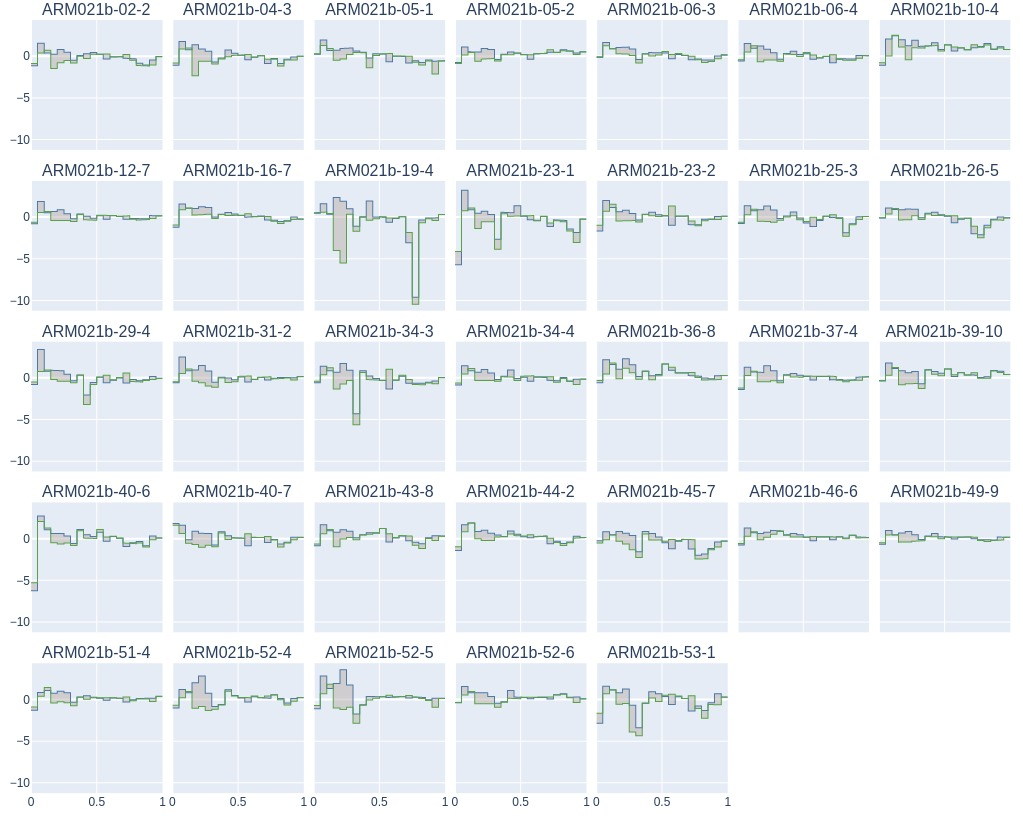

In [111]:
rows, cols = square_rows_cols(len(cellids))
fig = make_subplots(rows, cols, shared_xaxes='all', shared_yaxes='all', subplot_titles=cellids,
                    horizontal_spacing=0.01, vertical_spacing=0.04)

for ii, (rr, cc) in enumerate(itt.product(range(rows), range(cols))):
    if ii == len(cellids): break
    traces = plot_raw_pair_array(fano_var_diag, cellids, cellids[ii], ctx_pair, probe, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend)['data']
    fig.add_traces(traces, rows=[rr+1]*len(traces), cols=[cc+1]*len(traces))

fig.update_traces(line=dict(width=1))
fig.update_layout(width=104*25/2.54, height=104*20/2.54,
                  margin=dict(l=10, r=10, t=20, b=10),
                  showlegend=False)

# filename = folder / 'diag_site_eg_psths'
# fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')

# old pairwise MES
this approach ended up not making much sense

In [ ]:
"""
control for mean square error, deprecated

after checking the effect of diagonalization on a full site, namely the pairwise difference metric (integral), it is
clear that this differences, are greater than on the original data. This is specially clear when
summing the differences acrossall the neurons in a site.

We believe this should not be the case, and that a furthe constrain has to be considered:
the mean squared difference across the population between each stim pair should be equal between sparse and dense data
"""
def get_pairwise_MSE(fnArr):
    rep, chn, ctx, prb, tme = fnArr.shape
    ctx_pairs = list(itt.combinations(range(ctx), 2))
    diff_arr = np.empty([rep, chn, len(ctx_pairs), prb, tme])
    for cpidx, (c0, c1) in enumerate(ctx_pairs):
        diff_arr[:, :, cpidx, :, :] = fnArr[:, :, c0, :, :] - fnArr[:, :, c1, :, :]

    return  diff_arr ** 2

def scale_diagonal_loss(fnScaler, fnArr, fnDiag):
    rep, chn, ctx, prb, tme = fnArr.shape

    # calculate original MSE for the PSHTs!
    ogMSE = get_pairwise_MSE(fnArr.mean(axis=0, keepdims=True))


    # ensures the right shape of the scaler so it can be broadcasted to
    # probes and time
    fnScaler = np.reshape(fnScaler.flatten(), [1,1,1,prb,tme])

    # calculate the MSE for the scaled diagonalized values
    # since the diagonalization is happening independently for each
    # probe, and time the scaling is done in the same way
    transformed = fnScaler * (fnArr + fnDiag)
    diagMSE = get_pairwise_MSE(transformed.mean(axis=0, keepdims=True)) # on PSTH!

    # here for the loss, I am initially taking the sum over cells and contexts, since these are the ones that
    # are changing individually, but that we want to keep constant when looking at the whole site
    # then the loss is calcualted as the mean of errors across probes and times
    # loss = np.mean((ogMSE.sum(axis=(1,2)) - diagMSE.sum(axis=(1,2))) ** 2)

    # alternatively try to match individual cell average instance, i.e., only take the sum over neurons
    loss = np.mean((ogMSE.mean(axis=(1)) - diagMSE.mean(axis=(1))) ** 2)

    return  loss


def get_diagonal_scaler(fnArr, fnDiag):
    rep, chn, ctx, prb, tme = fnArr.shape
    res = minimize(scale_diagonal_loss, np.ones([prb, tme]), method='nelder-mead',
               args=(fnArr, fnDiag), options={'xatol': 1e-8, 'disp': True})
    scaler = res.x.reshape([1,1,1,prb,tme])
    return scaler

# test_raster- no_prb_diag
# test_raster = raster[:,np.asarray(cellidx),...][...,0,0][:,:,:,None,None] # 2 neurons, 1 probe, 1 time point
# test_diagonalizer = get_diagonalizations(test_raster)
#
# test_scaler = get_diagonal_scaler(test_raster, test_diagonalizer)